In [1]:
import pytesseract
from PIL import Image
import pandas as pd
import json
import xml.etree.ElementTree as ET
import os
import csv

In [2]:
# Function to check if coordinates are within parent box
def is_within_parent_box(parent_box, box):
    xmin_parent, ymin_parent, xmax_parent, ymax_parent = parent_box
    xmin, ymin, xmax, ymax = box
    return xmin >= xmin_parent and ymin >= ymin_parent and xmax <= xmax_parent and ymax <= ymax_parent

In [ ]:
import os

# Define the folder containing the image files
folder_path = 'your folder path'

# Initialize a counter for the number of images
num_images = 0

# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        # Increment the counter for each image file found
        num_images += 1

In [4]:
num_images

1000

In [ ]:

# Define the folder containing the image files
folder_path = 'your folder path'
count=0

# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        #-----------------------Step1: Create OCR csv file-----------------------------------
        # Construct the full path to the image file
        image_path = os.path.join(folder_path, filename)
        
        # Perform OCR and get the result
        ocr_data = pytesseract.image_to_data(Image.open(image_path))
        
        # Convert the OCR data to a DataFrame
        ocr_df = pd.DataFrame([line.split('\t') for line in ocr_data.split('\n')])
        
        # Set column names
        column_names = ocr_df.iloc[0]
        ocr_df = ocr_df[1:]
        ocr_df.columns = column_names
        
        # Save the DataFrame to a CSV file
        ocr_filename = os.path.splitext(filename)[0] + '_ocr.csv'
        ocr_file_path = os.path.join(folder_path, ocr_filename)
        ocr_df.to_csv(ocr_file_path, index=False)


        # Read the CSV file
        df = pd.read_csv(ocr_file_path)

        # Calculate xmin, ymin, xmax, ymax
        df['xmin'] = df['left']
        df['ymin'] = df['top']
        df['xmax'] = df['left'] + df['width']
        df['ymax'] = df['top'] + df['height']

        # Overwrite the existing CSV file with the updated DataFrame
        df.to_csv(ocr_file_path, index=False)
        xml_filename = os.path.splitext(filename)[0] + '.xml'
        # Parse the XML file
        tree = ET.parse(xml_filename)
        root = tree.getroot()

        # Initialize lists to store data
        labels = []
        xmin_list = []
        ymin_list = []
        xmax_list = []
        ymax_list = []

        # Extract data from XML
        for obj in root.findall('object'):
            label = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            
            # Append data to lists
            labels.append(label)
            xmin_list.append(xmin)
            ymin_list.append(ymin)
            xmax_list.append(xmax)
            ymax_list.append(ymax)

        # Create a DataFrame
        data = {
            'Label': labels,
            'Xmin': xmin_list,
            'Ymin': ymin_list,
            'Xmax': xmax_list,
            'Ymax': ymax_list
        }
        df = pd.DataFrame(data)

        csv_filename = os.path.splitext(filename)[0] + '.csv'
        csv_file_path = os.path.join(folder_path, csv_filename)
        # Save DataFrame to CSV
        df.to_csv(csv_file_path, index=False)



        # Initialize a list to store the form data
        form_data = []

        # Open the image
        image = Image.open(image_path)
        # Iterate through each row in the DataFrame
        for index, row in df.iterrows():
            # Extract label and bounding box coordinates
            label = row['Label']
            xmin, ymin, xmax, ymax = row['Xmin'], row['Ymin'], row['Xmax'], row['Ymax']
            
            # Crop the image to get the text within the bounding box
            cropped_image = image.crop((xmin, ymin, xmax, ymax))
            
            # Perform OCR to extract text from the cropped image
            text = pytesseract.image_to_string(cropped_image)
            
            # Create a dictionary for the form data
            form_item = {
                "text": text.strip(),
                "box": [xmin, ymin, xmax, ymax],
                "label": label,
                "words": [],  # We'll populate this later
                "linking": [],  # We'll populate this later
                "id": index
            }
            
            # Append the form item to the form data list
            form_data.append(form_item)
        # Create the final JSON structure
        json_data = {"form": form_data}
        json_filename = os.path.splitext(filename)[0] + '.json'
        json_file_path = os.path.join(folder_path, json_filename)

        # Save the JSON data to a file
        with open(json_file_path, 'w') as json_file:
            json.dump(json_data, json_file)

        # Load the JSON data
        with open(json_file_path, 'r') as json_file:
            words_data = json.load(json_file)

        # Load CSV data and create words list
        with open(ocr_file_path, 'r') as csv_file:
            csv_reader = csv.DictReader(csv_file)
            for row in csv_reader:
                word_text = row['text']
                try:
                    word_box = (float(row['xmin']), float(row['ymin']), float(row['xmax']), float(row['ymax']))
                except ValueError:
                    print(word_text)
                    # Skip this word if any of the coordinates are empty
                    continue
                
                # Iterate through parent items in the JSON data
                for parent_item in words_data['form']:
                    parent_box = parent_item['box']
                    # print(is_within_parent_box(parent_box, word_box))
                    # Check if word box is within parent box
                    if word_text and is_within_parent_box(parent_box, word_box):
                        # Append word text and box to the words list of the corresponding parent
                        parent_item['words'].append({"text": word_text, "box": word_box})
        json_filename = os.path.splitext(filename)[0] + '.json'
        json_file_path = os.path.join(folder_path, json_filename)

        # Save the modified JSON data to a new file
        with open(json_file_path, 'w') as json_output:
            json.dump(words_data, json_output, indent=4)
        count+=1
        print(f'{count}/{num_images} {filename}')


In [26]:
from PIL import Image, ImageDraw, ImageFont

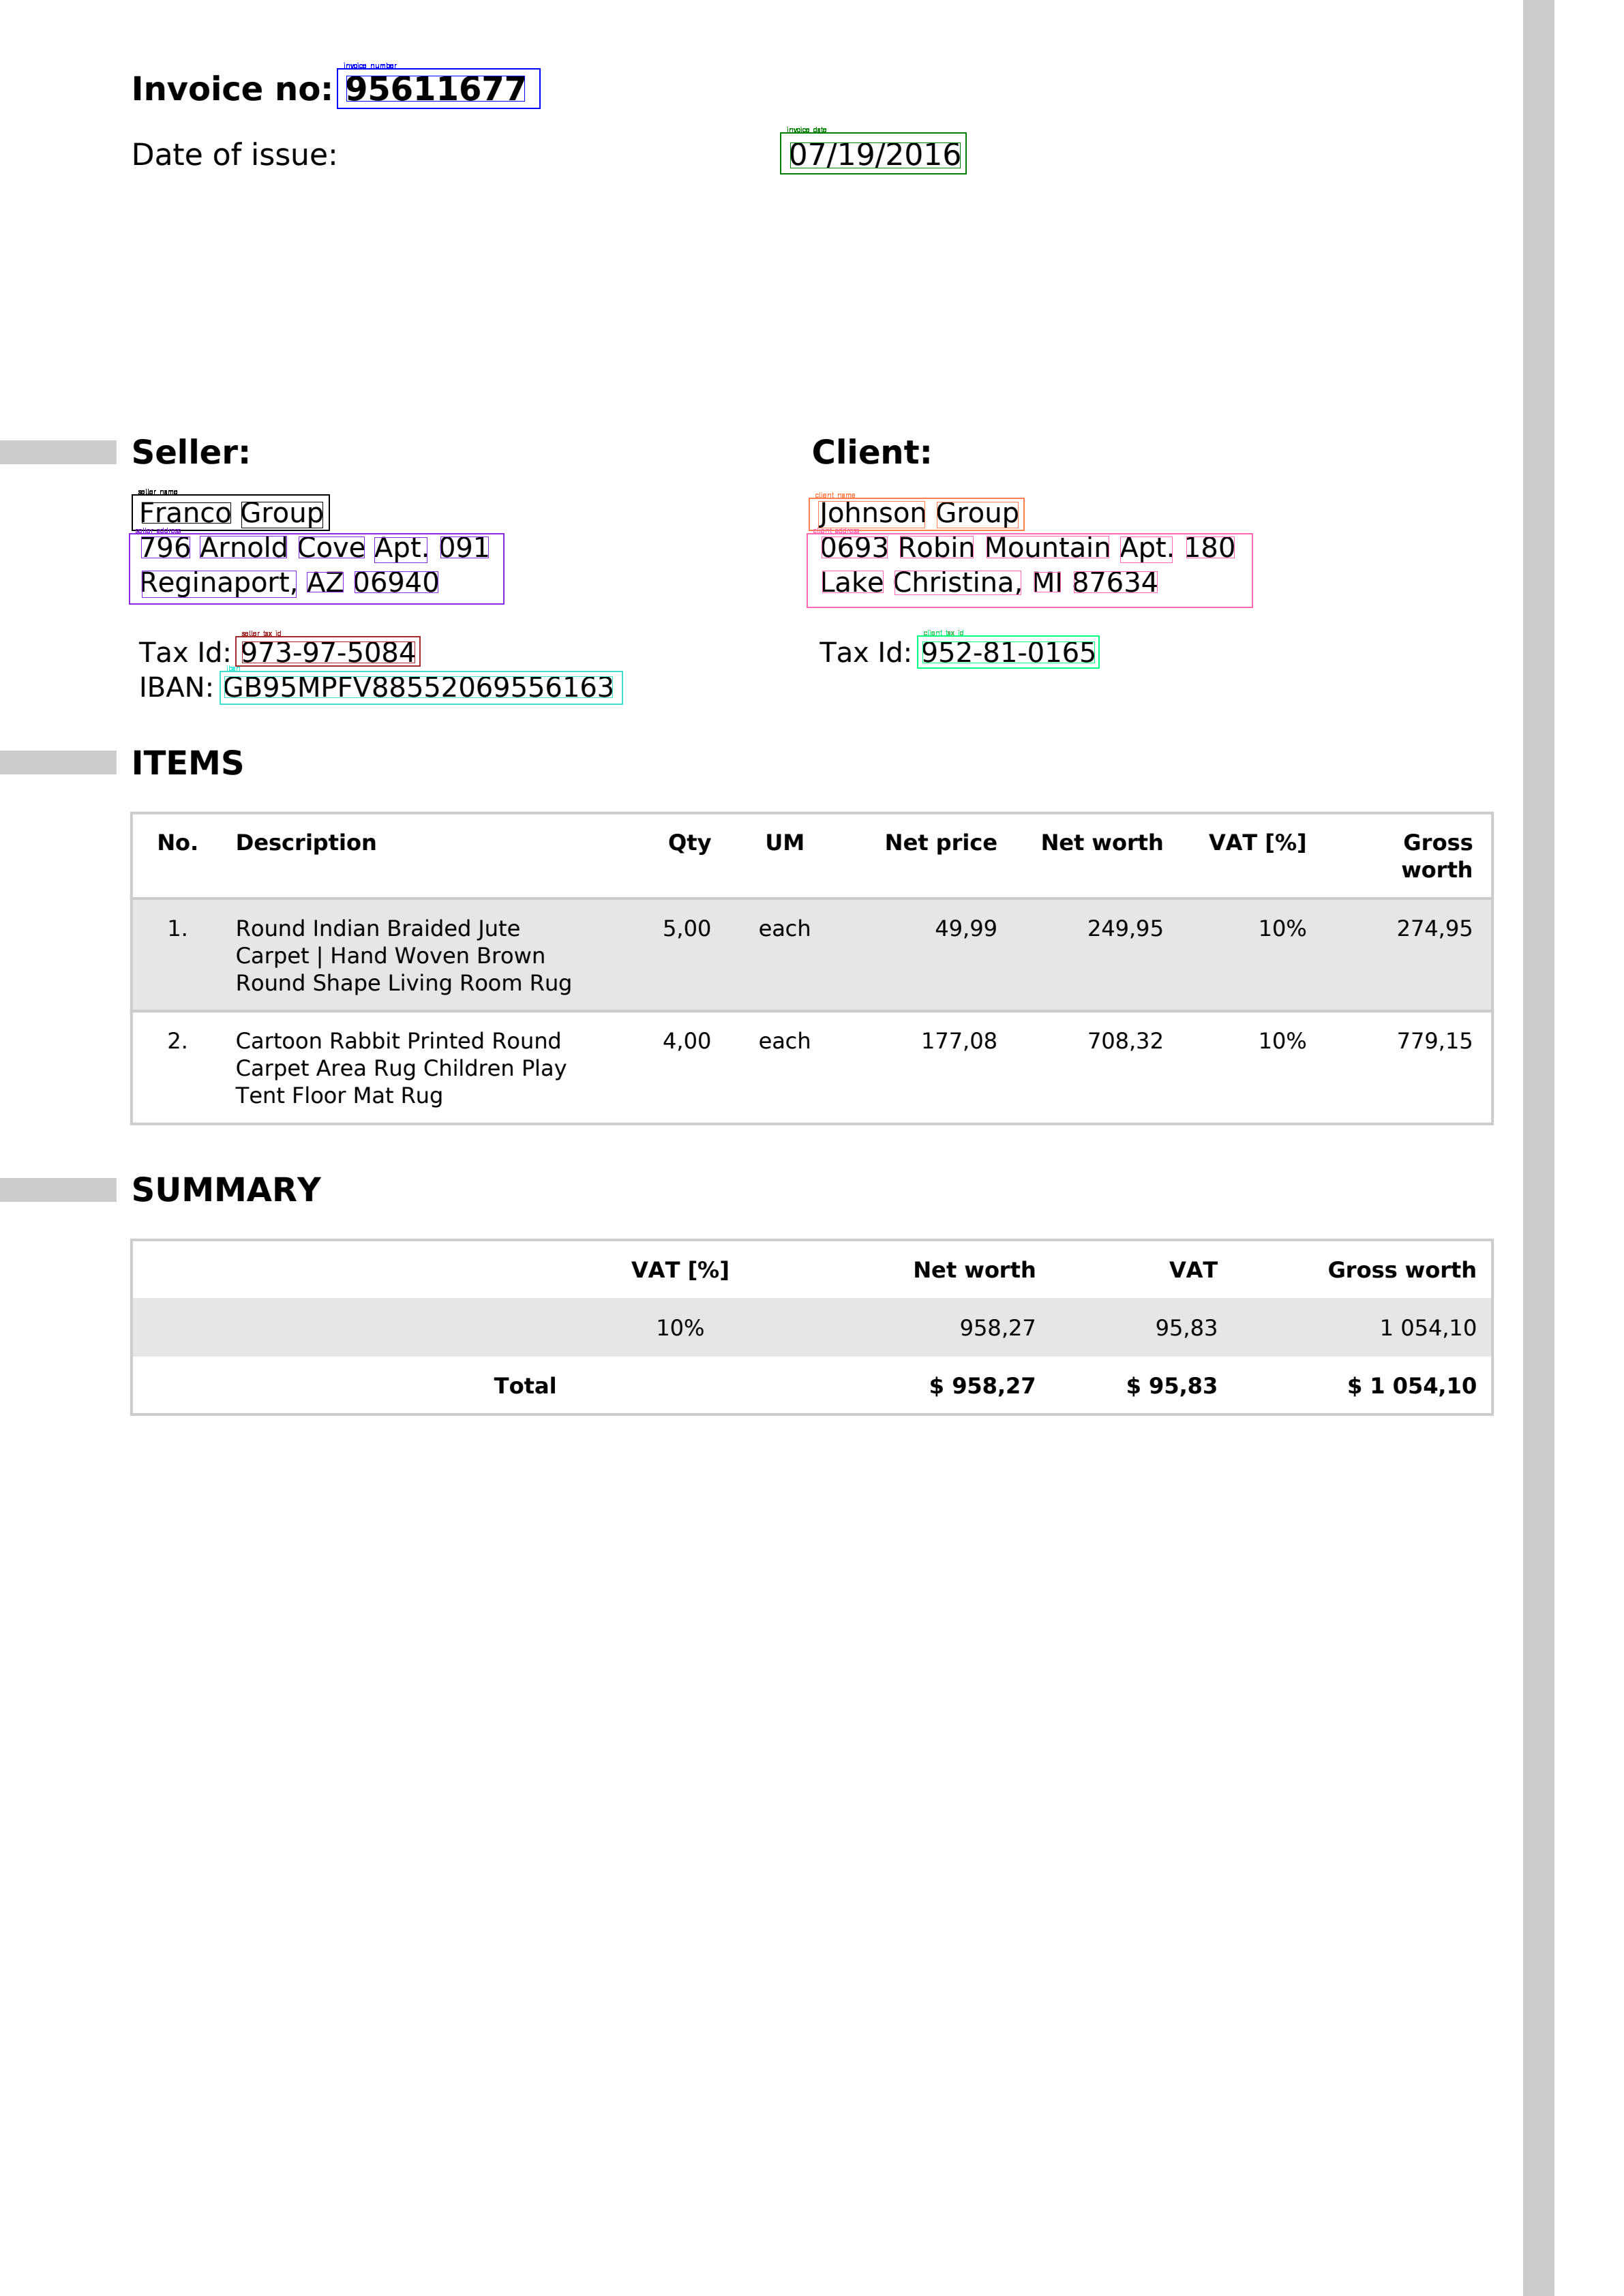

In [34]:
draw = ImageDraw.Draw(image, "RGBA")

font = ImageFont.load_default()

label2color = {'invoice_number':'blue', 'invoice_date':'green', 'client_name':'coral', 'client_address':'hotpink', 'client_tax_id': 'springgreen', 'seller_name': 'black', 'seller_address': 'blueviolet', 'seller_tax_id': 'brown', 'iban': 'turquoise'}

for annotation in data['form']:
  label = annotation['label']
  general_box = annotation['box']
  draw.rectangle(general_box, outline=label2color[label], width=2)
  draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)
  words = annotation['words']
  for word in words:
    box = word['box']
    draw.rectangle(box, outline=label2color[label], width=1)

image